<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_SS/blob/main/Lecture08/Notebook_SS08_Spatial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Spatial Data Cross-validation

## Predicting House Prices

Our objective today is to construct a model to predict house prices. From Rosen's landmark paper "Hedonic Prices and Implicit Markets: Product Differentiation in Pure Competition" (1974), we know that a vector of its characteristics describes a differentiated good.

In the case of a house, these characteristics may include structural attributes (e.g., number of bedrooms), neighborhood public services (e.g., local school quality), and local amenities (e.g., crime, air quality, etc). Thus, we can write the market price of the house as:

$$
Price=f(structural\,attributes,amenities,...)
$$


However, Rosen's theory doesn't tell us much about the functional form of $f$. 

### The Ames Housing Data

For this exersise we are going to use housing data from Ames, Iowa, available on the `modeldata` package.

Let's load the packages:

In [1]:
# install.packages("pacman") #run this line if you use Google Colab

In [2]:
#packages
require("pacman")
p_load("tidyverse", #data wrangling
       "modeldata", # package with the housing data from Ames, Iowa
       "vtable", #descriptive stats package
       "stargazer", #tidy regression results,
       "sf", #handling spatial data
       "spatialsample") #spatial CV



Loading required package: pacman



 And the data set:

In [3]:
data("ames", package = "modeldata")

The Ames housing data is a normal [tibble](https://tibble.tidyverse.org/).

In [4]:
head(ames)

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,⋯,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,5,2010,WD,Normal,215000,-93.61975,42.05403
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.61976,42.05301
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,⋯,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.61939,42.05266
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,⋯,No_Fence,None,0,4,2010,WD,Normal,244000,-93.61732,42.05125
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.63893,42.06090
Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,⋯,No_Fence,None,0,6,2010,WD,Normal,195500,-93.63893,42.06078


The description of the variables can be viewed here: https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

### Modelling Prices

Let's say that the logarithm of sale price of these houses is a linear model on their living area (size),  the type of house, and the Neighboorhood:


In [5]:
ames_sub<-ames %>% select(Sale_Price, Gr_Liv_Area,  Bldg_Type,Neighborhood)

In [6]:
class(ames_sub$Bldg_Type)

[1] "factor"

In [7]:
sumtable(ames_sub, out ="return")

Variable,N,Mean,Std. Dev.,Min,Pctl. 25,Pctl. 75,Max
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sale_Price,2930,180796,79887,12789,129500,213500,755000
Gr_Liv_Area,2930,1500,506,334,1126,1743,5642
Bldg_Type,2930,,,,,,
... OneFam,2425,83%,,,,,
... TwoFmCon,62,2%,,,,,
... Duplex,109,4%,,,,,
... Twnhs,101,3%,,,,,
... TwnhsE,233,8%,,,,,
Neighborhood,2930,,,,,,


We can write the linear model as:


$$
log(Sale\,Price)_{ij}= \beta_0 + \beta_1 Living\,Area_i+\beta_2 I(Two-family\,Conversion=1) +
\beta_3 I(Duplex=1) +\beta_4 I(Townhouse\,End\,Unit=1)+\beta_5 I(Townhouse\,Inside\,Unit) + \alpha_j + u_{ij} 
$$

and we can run the linear regression:

In [52]:
reg1<-lm(log(Sale_Price) ~ Gr_Liv_Area  + Bldg_Type + Neighborhood,data=ames_sub)
stargazer(reg1,type="text")


                                                        Dependent variable:    
                                                    ---------------------------
                                                          log(Sale_Price)      
-------------------------------------------------------------------------------
Gr_Liv_Area                                                  0.0004***         
                                                             (0.00001)         
                                                                               
factor(Bldg_Type)TwoFmCon                                    -0.096***         
                                                              (0.026)          
                                                                               
factor(Bldg_Type)Duplex                                      -0.206***         
                                                              (0.020)          
                                       

<iframe src="m.html"></iframe>

## Spatial Dependence

We are going to turn  our data into an [sf](https://r-spatial.github.io/sf/) object to properly handle spatial distance calculations. 
 
 We can transform our Ames data into an sf object using the `sf::st_as_sf()` function:

In [57]:
#For speed I'm going to keep the ten neighbourhoods with most observations
ames<-ames  %>% filter(Neighborhood %in%c("North_Ames", "College_Creek", "Old_Town", "Edwards", "Somerset", "Northridge_Heights", "Gilbert", "Sawyer", "Northwest_Ames", "Sawyer_West"))

ames_sf <- st_as_sf(
  ames,
  # "coords" is in x/y order -- so longitude goes first!
  coords = c("Longitude", "Latitude"),
  # Set our coordinate reference system to EPSG:4326,
  # the standard WGS84 geodetic coordinate reference system
  crs = 4326
)

### Interactive Viz

In [58]:
p_load("leaflet")

map<-leaflet() %>% 
  addTiles() %>%  #capa base
  addCircles(data=ames_sf) #capa casas
map 

HTML widgets cannot be represented in plain text (need html)

In [59]:
#Extra steps bc of jupyter notebook (if you are in RStudio, you don't need these steps)
p_load("htmlwidgets") 
p_load("IRdisplay")
saveWidget(map, file="m.html")
display_html('<iframe width="900" height="700" src="m.html"></iframe>')

### Spatial Autocorrelation

This relationship may exhibit spatial autocorrelation across the city of Ames, and we can use any of the several different methods provided by spatialsample to try and investigate it. 


This relationship may exhibit spatial autocorrelation across the city of Ames, and we can use any of the several different methods provided by spatialsample to try and investigate it. 


#### Spatial Buffers

The `spatial_buffer_vfold_cv()` function will perform [spatially buffered cross-validation](https://onlinelibrary.wiley.com/doi/10.1111/geb.12161) with your data:

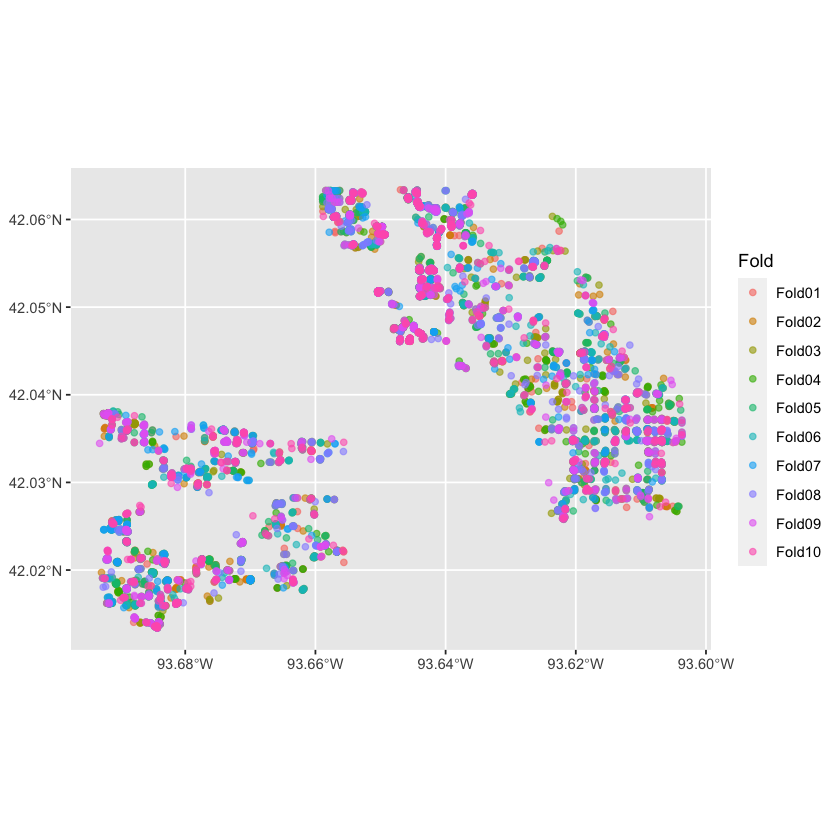

In [62]:
set.seed(123)
buffer_folds <- spatial_buffer_vfold_cv(ames_sf, radius=40,buffer=5)

autoplot(buffer_folds)

#### Spatial Blocks

For instance, the `spatial_block_cv()` function will perform [spatial blocking](https://doi.org/10.1111/ecog.02881) with your data:

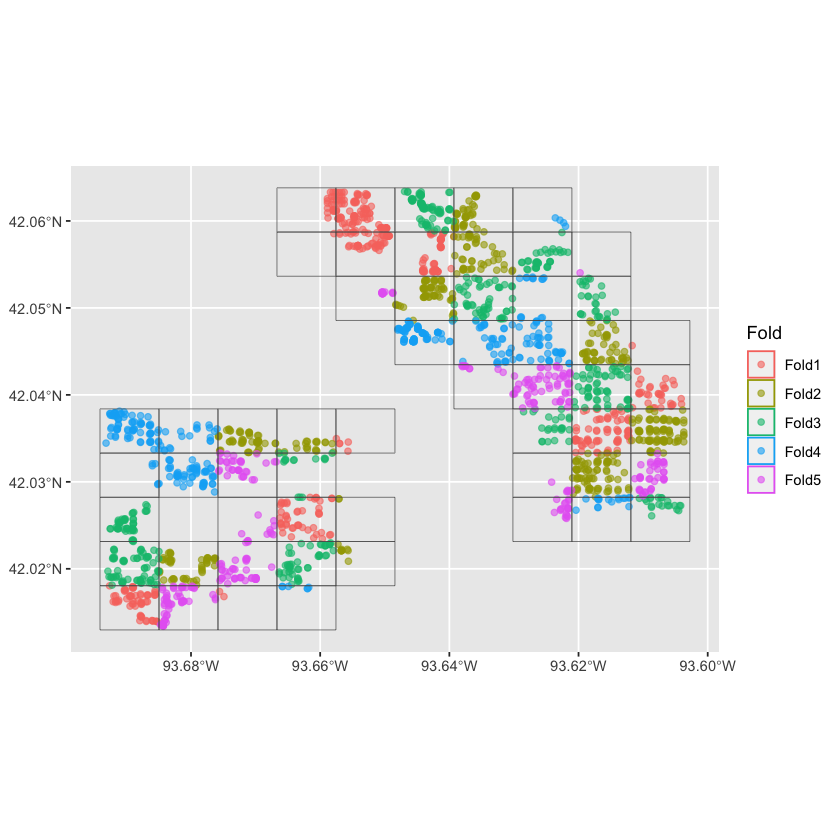

In [13]:
set.seed(123)
block_folds <- spatial_block_cv(ames_sf, v = 5)

autoplot(block_folds)

#### Spatial LLOCV

If you already have a sense of what locations in your data are likely to be closely related, you can also use the `spatial_leave_location_out_cv()` function to perform [leave-location-out cross-validation](https://doi.org/10.1016/j.envsoft.2017.12.001). 

For instance, we can split the Ames data into folds based on neighborhoods using this function:

In [14]:
set.seed(123)

location_folds <- 
  spatial_leave_location_out_cv(
    ames_sf,
    group = Neighborhood
  )

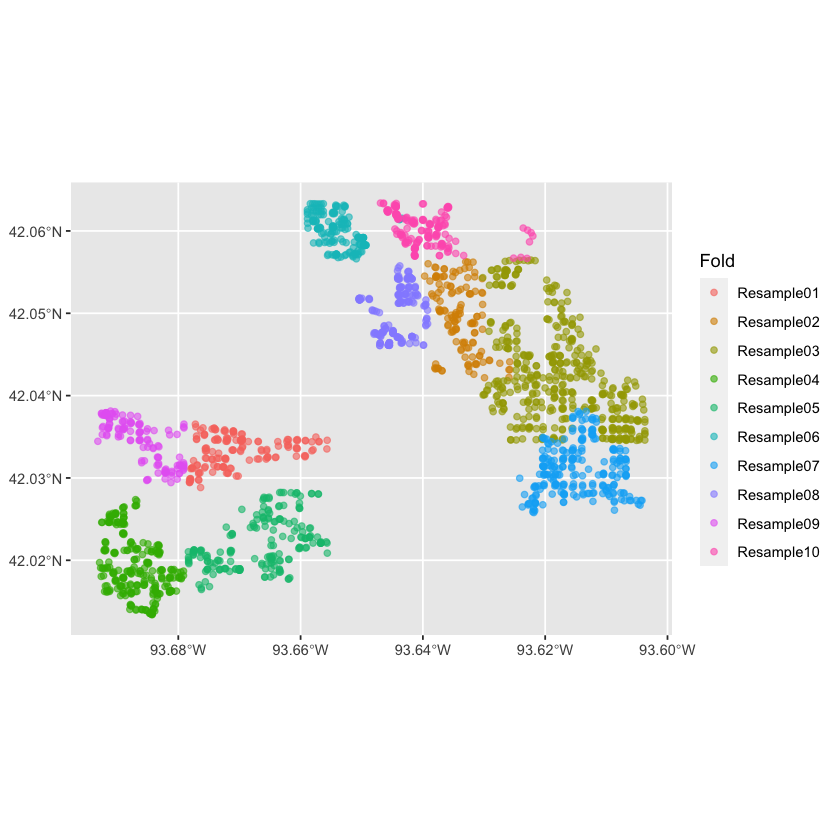

In [15]:
autoplot(location_folds)

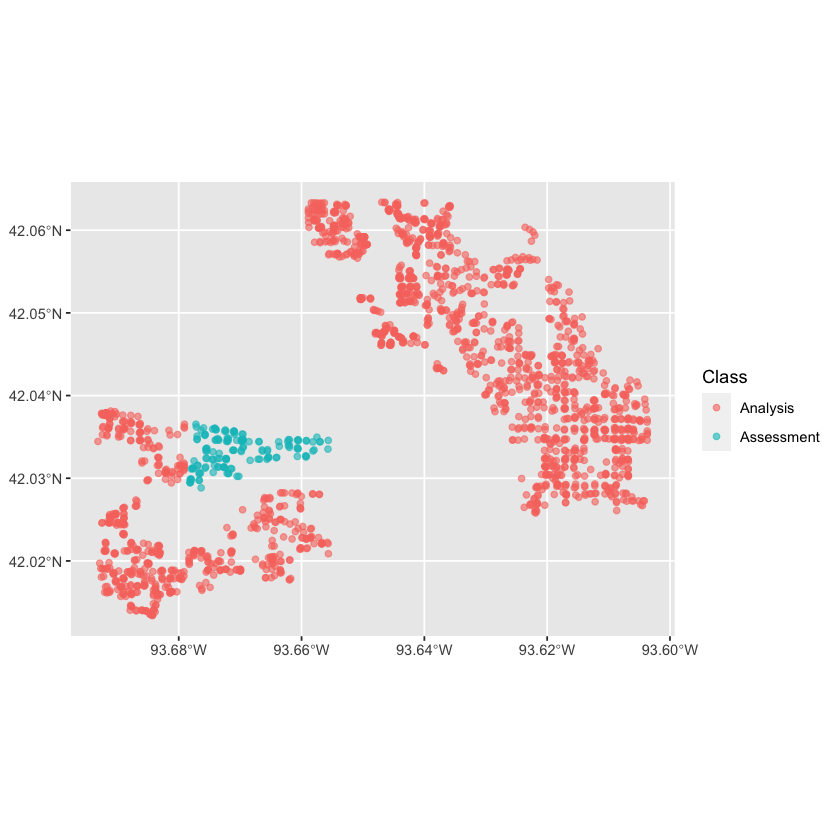

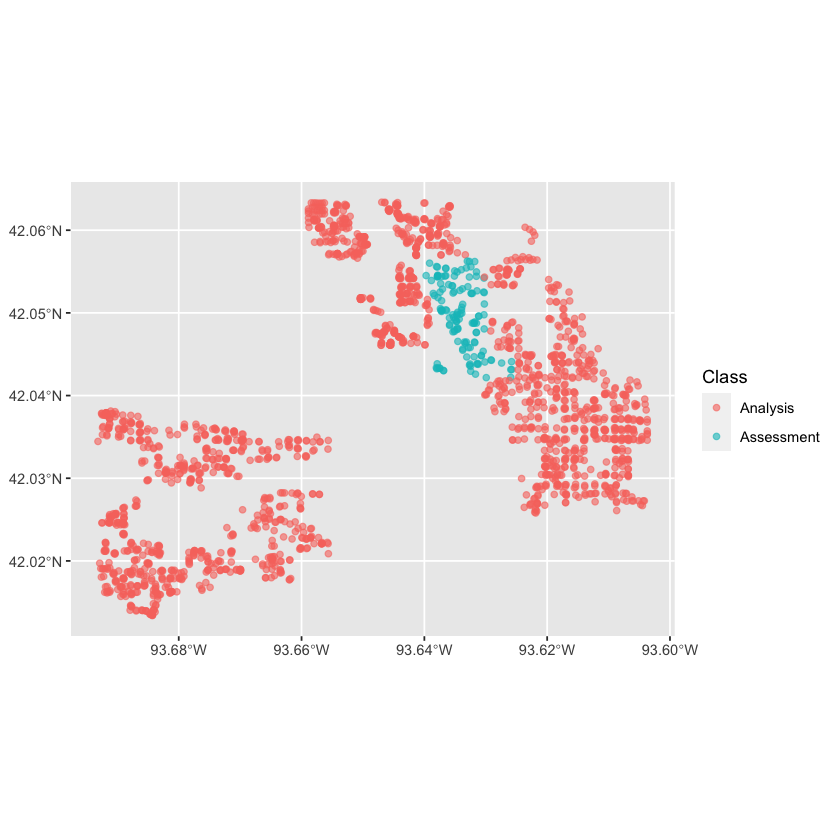

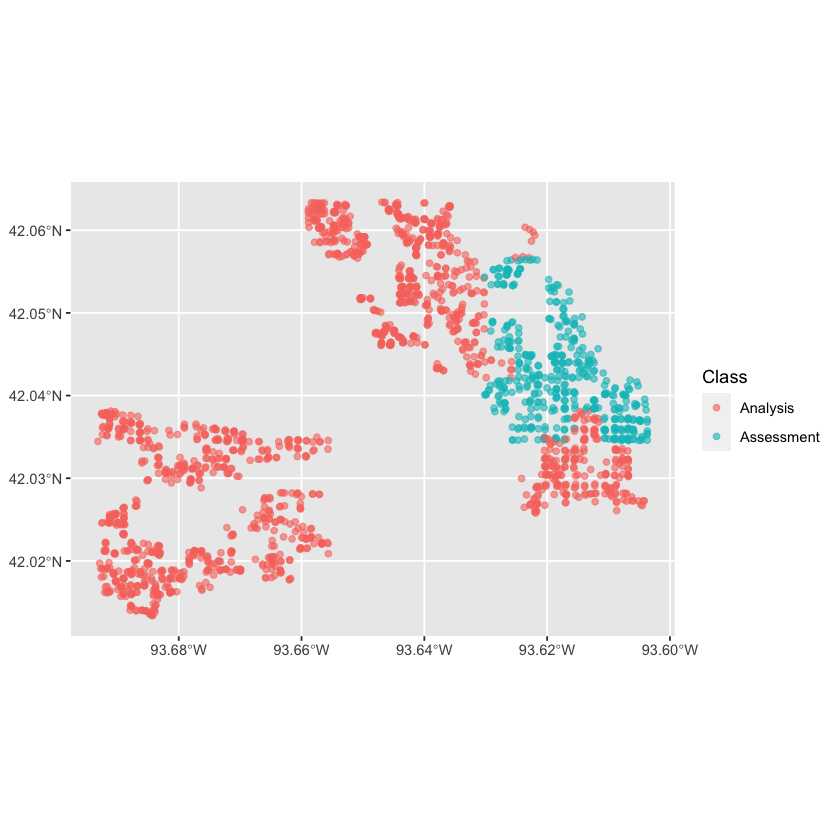

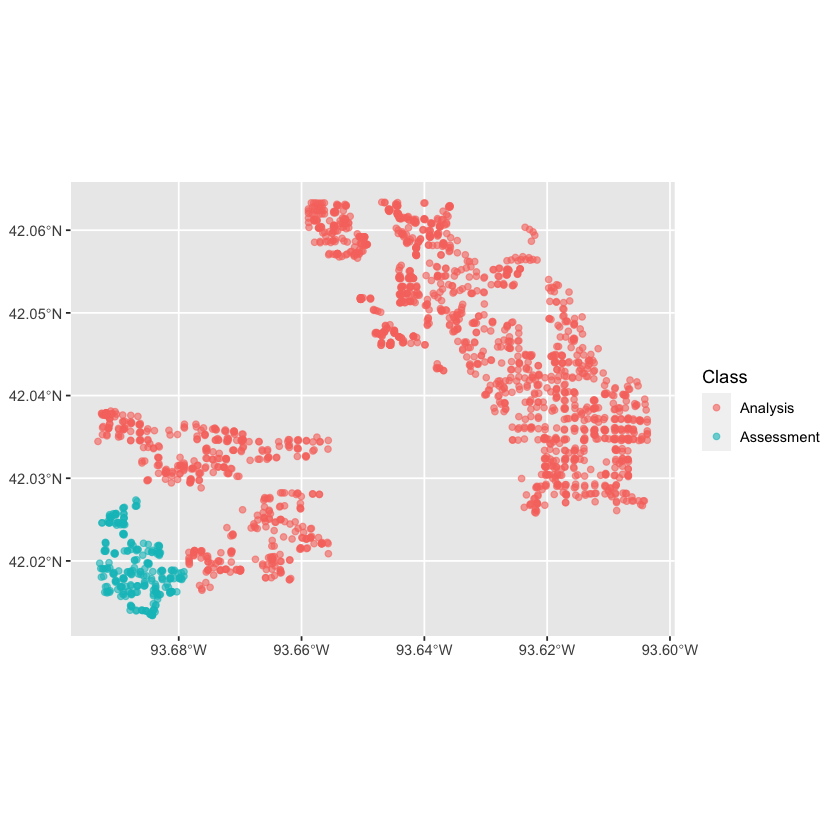

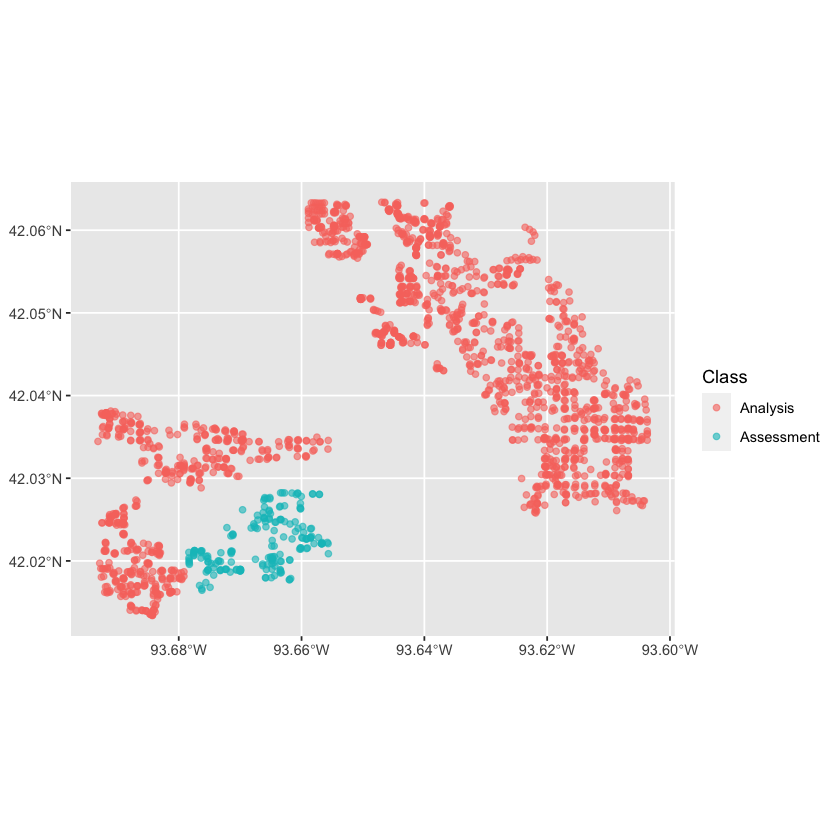

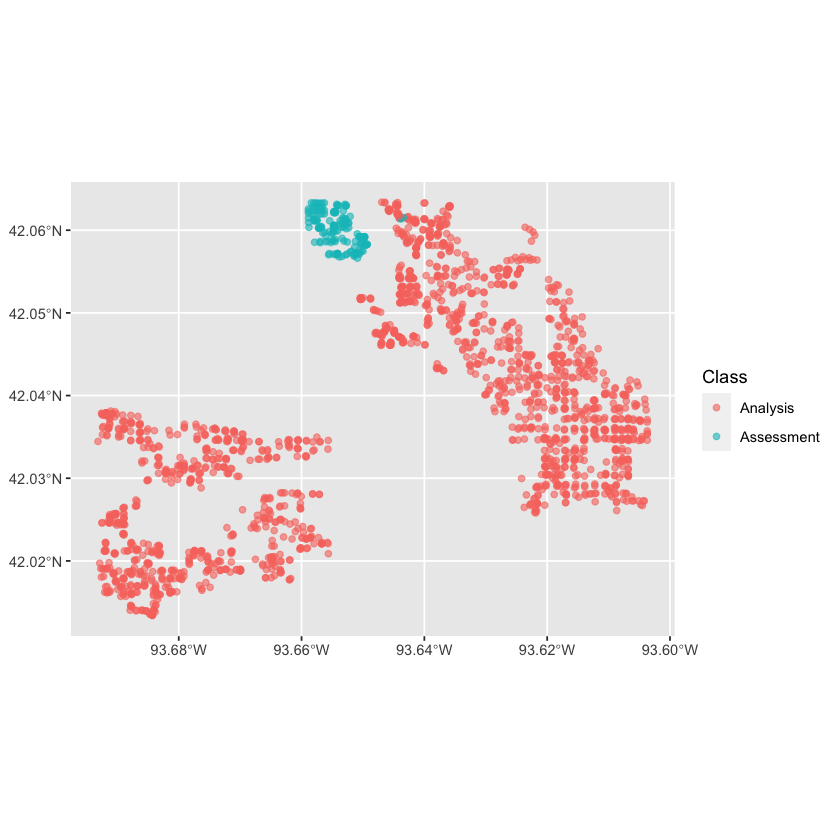

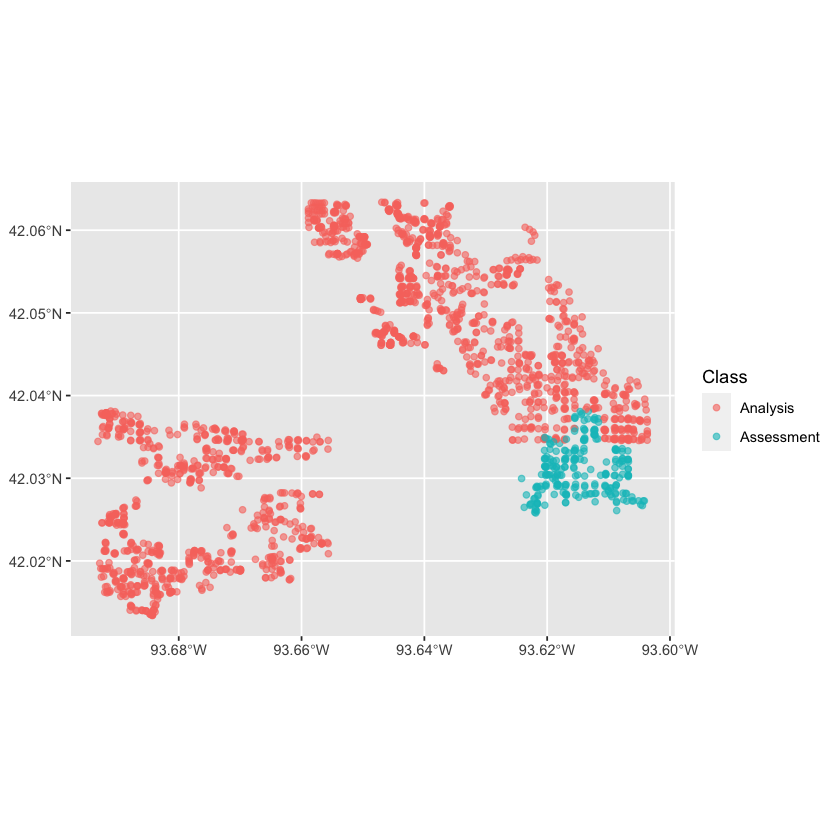

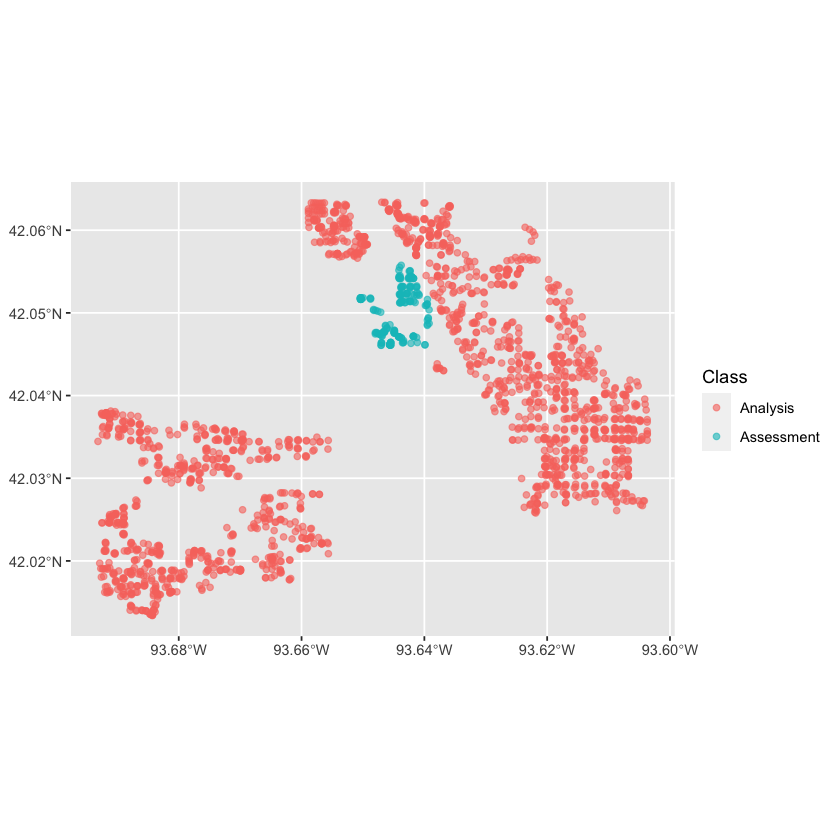

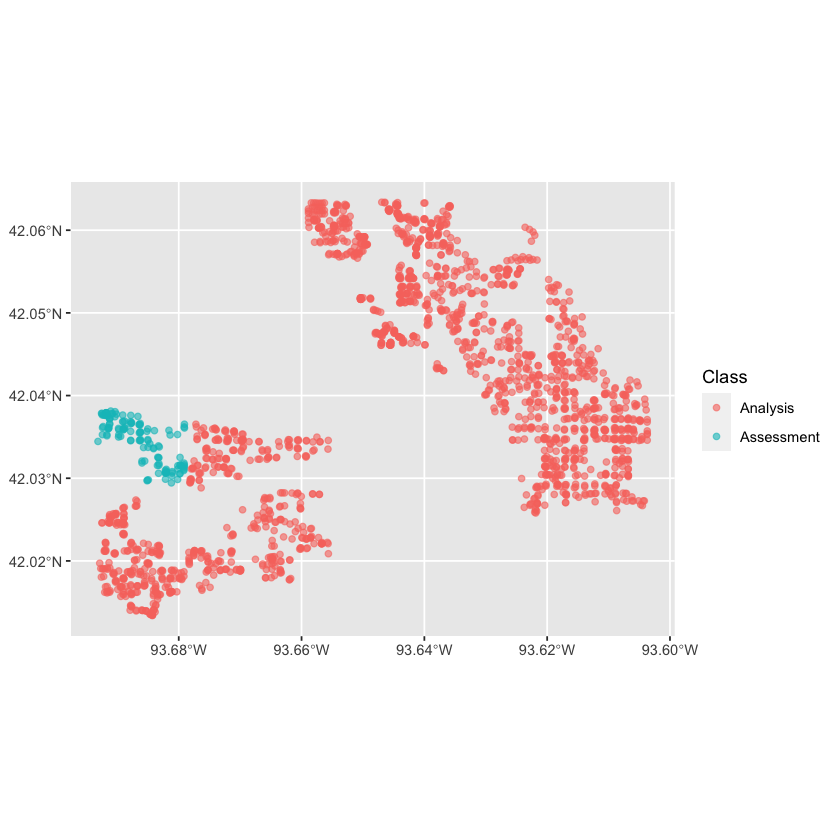

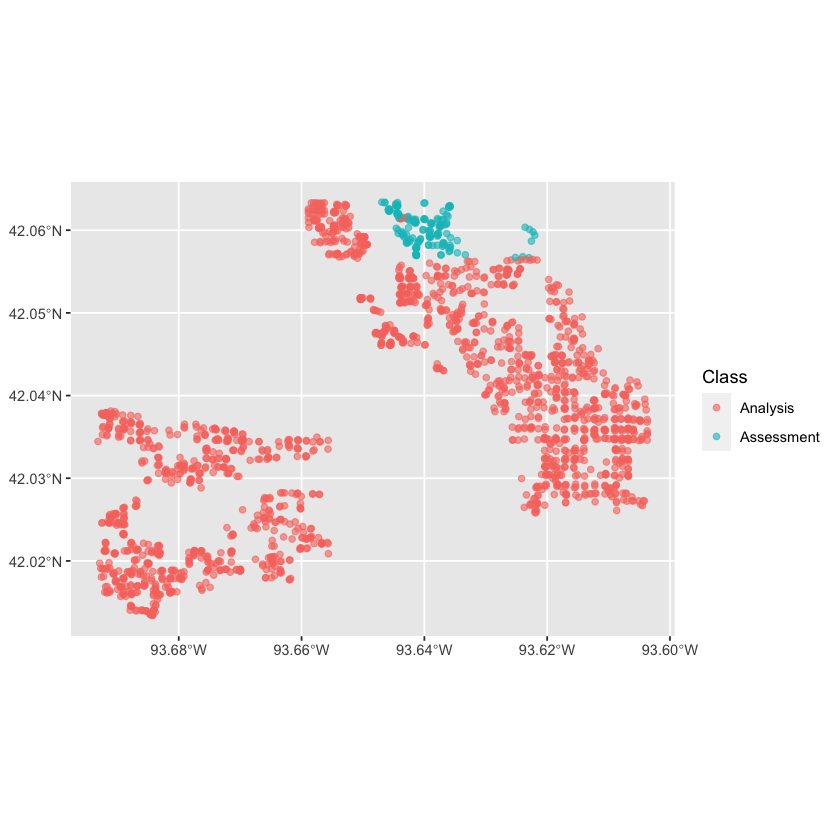

In [16]:
p_load("purrr")

walk(location_folds$splits, function(x) print(autoplot(x)))

## Full implementation with Elastic Net

\begin{align}
min_{\beta} EN(\beta) &= \sum_{i=1}^n (y_i-\beta_0 - \sum_{j=1}^p x_{ij}\beta_j)^2  + \lambda\left(\alpha \sum_{j=1}^p |\beta_j| + \frac{(1-\alpha)}{2} \sum_{j=1}^p (\beta_j)^2\right)
\end{align}

In [17]:
folds<-list()

for(i in 1:10){
  folds[[i]]<- location_folds$splits[[i]]$in_id
}


In [64]:
head(folds[[1]])

[1] 1 2 3 4 5 6

In [19]:
folds[[2]][!(folds[[2]]%in%folds[[1]])]

[1]   62   63   64   65   66   67   68   82  169  170  171  172  173  174  175
 [16]  176  177  178  179  180  181  182  183  406  407  408  409  410  411  412
 [31]  413  414  424  577  584  585  586  587  588  589  590  591  592  593  594
 [46]  595  838  839  840  841  842  843  844 1010 1011 1012 1014 1015 1016 1017
 [61] 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032
 [76] 1033 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1342 1490
 [91] 1492 1493 1494 1495 1496 1497 1498 1499 1500 1501 1502 1503 1504 1505 1506
[106] 1507 1508 1509 1510 1511 1512 1513 1514 1759 1760 1761 1762 1763 1764 1765
[121] 1766 1767 1768 1769 1770 1771 1931 1932 1933 1935 1936 1937 1938 1939 1940
[136] 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955
[151] 1956

In [20]:
p_load("caret")

fitControl<-trainControl(method ="cv",
                         index=folds)



In [21]:
EN<-train(log(Sale_Price) ~ Gr_Liv_Area  +  Bldg_Type ,
             data=ames_sf,
             method = 'glmnet', 
             trControl = fitControl,
             tuneGrid = expand.grid(alpha =seq(0,1,length.out = 20),
                                    lambda = seq(0.001,0.2,length.out = 50))
              ) 

In [22]:
EN

glmnet 

2063 samples
   3 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1912, 1932, 1620, 1796, 1869, 1897, ... 
Resampling results across tuning parameters:

  alpha       lambda       RMSE       Rsquared   MAE      
  0.00000000  0.001000000  0.2626262  0.4527755  0.2060893
  0.00000000  0.005061224  0.2626262  0.4527755  0.2060893
  0.00000000  0.009122449  0.2626262  0.4527755  0.2060893
  0.00000000  0.013183673  0.2626262  0.4527755  0.2060893
  0.00000000  0.017244898  0.2626262  0.4527755  0.2060893
  0.00000000  0.021306122  0.2627131  0.4527827  0.2061781
  0.00000000  0.025367347  0.2630140  0.4528230  0.2064952
  0.00000000  0.029428571  0.2630730  0.4529527  0.2067519
  0.00000000  0.033489796  0.2631526  0.4530781  0.2070232
  0.00000000  0.037551020  0.2632564  0.4532002  0.2073150
  0.00000000  0.041612245  0.2633820  0.4533192  0.2076236
  0.00000000  0.045673469  0.2635281  0.4534351  0.2079495
  0.00000000  0.049734694 

In [23]:
EN$bestTune

,alpha,lambda
,<dbl>,<dbl>
5,0,0.0172449


In [44]:
round(EN$results$RMSE[which.min(EN$results$lambda)],4)

[1] 0.2626

In [25]:
fitControl2<-trainControl(method ="cv",
                         number=5)

EN2<-train(log(Sale_Price) ~ Gr_Liv_Area  +  Bldg_Type ,
             data=ames_sf,
             method = 'glmnet', 
             trControl = fitControl2,
             tuneGrid = expand.grid(alpha =seq(0,1,length.out = 20),
                                    lambda = seq(0.001,0.2,length.out = 50))
              ) 



[1] 0.265139

In [45]:
round(EN2$results$RMSE[which.min(EN2$results$lambda)],4)

[1] 0.2651

## Example Problem Set

In [26]:
test<- ames_sf  %>% filter(Neighborhood=="North_Ames")

train<-ames_sf  %>% filter(Neighborhood!="North_Ames")

In [27]:
set.seed(123)

location_folds_train <- 
  spatial_leave_location_out_cv(
    train,
    group = Neighborhood
  )



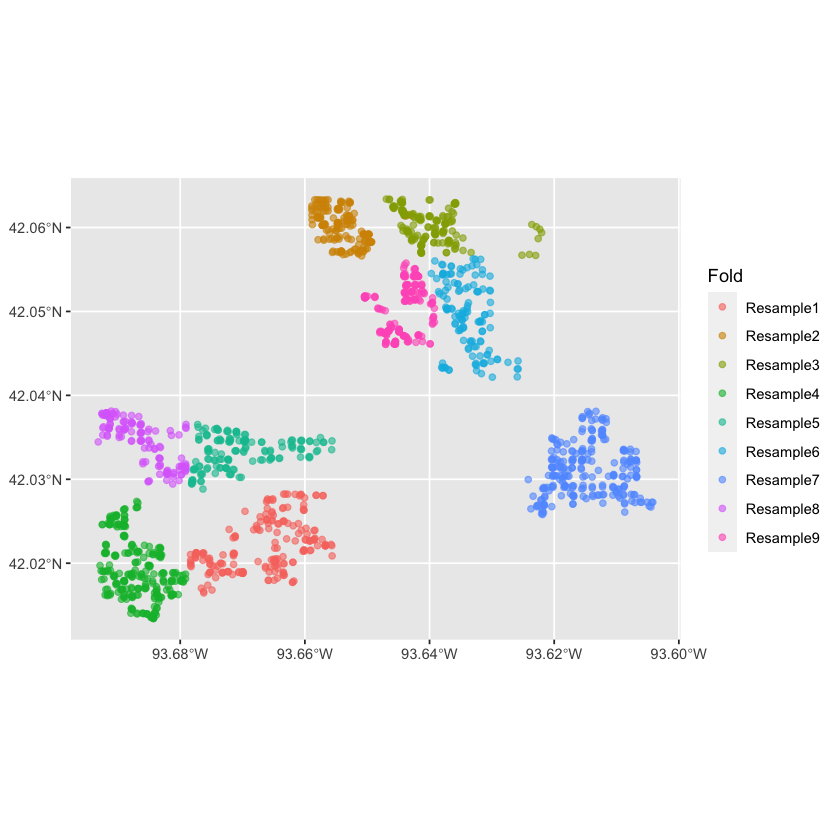

In [28]:
autoplot(location_folds_train)

In [29]:
folds_train<-list()
for(i in 1:length(location_folds_train$splits)){
  folds_train[[i]]<- location_folds_train$splits[[i]]$in_id
}


In [30]:
fitControl_tp<-trainControl(method ="cv",
                         number=5)



In [72]:
EN_tp<-train(log(Sale_Price) ~ Gr_Liv_Area:Bldg_Type ,
             data=train,
             method = 'glmnet', 
             trControl = fitControl_tp,
             metric="MAE",
             tuneGrid = expand.grid(alpha =seq(0,1,length.out = 20),
                                    lambda = seq(0.001,0.2,length.out = 50))
              ) 

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


In [32]:
EN_tp

glmnet 

1620 samples
   3 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1426, 1454, 1455, 1353, 1469, 1489, ... 
Resampling results across tuning parameters:

  alpha       lambda       RMSE       Rsquared   MAE      
  0.00000000  0.001000000  0.2747891  0.4516070  0.2168726
  0.00000000  0.005061224  0.2747891  0.4516070  0.2168726
  0.00000000  0.009122449  0.2747891  0.4516070  0.2168726
  0.00000000  0.013183673  0.2747891  0.4516070  0.2168726
  0.00000000  0.017244898  0.2747891  0.4516070  0.2168726
  0.00000000  0.021306122  0.2747960  0.4516083  0.2168798
  0.00000000  0.025367347  0.2750925  0.4516609  0.2171856
  0.00000000  0.029428571  0.2751758  0.4518359  0.2174669
  0.00000000  0.033489796  0.2751740  0.4520579  0.2176926
  0.00000000  0.037551020  0.2751944  0.4522747  0.2179321
  0.00000000  0.041612245  0.2752362  0.4524863  0.2181767
  0.00000000  0.045673469  0.2752988  0.4526927  0.2184421
  0.00000000  0.049734694 

In [66]:
EN_tp$bestTune

,alpha,lambda
,<dbl>,<dbl>
6,0,0.02130612


In [73]:
test$log_price_hat<-predict(EN_tp,newdata = test)

In [74]:
head(test  %>% select(Sale_Price,log_price_hat)  %>% st_drop_geometry())

Sale_Price,log_price_hat
<int>,<dbl>
215000,12.14134
105000,11.72142
172000,11.96066
244000,12.39219
149000,11.78109
149900,11.82198


In [75]:
test<- test  %>% mutate(price_hat=exp(log_price_hat))
head(test  %>% select(Sale_Price,log_price_hat,price_hat)  %>% st_drop_geometry())

Sale_Price,log_price_hat,price_hat
<int>,<dbl>,<dbl>
215000,12.14134,187463.6
105000,11.72142,123182.4
172000,11.96066,156477.0
244000,12.39219,240911.8
149000,11.78109,130756.8
149900,11.82198,136213.8


#### What is Kaggle's score?

In [76]:
#MAE
mean(abs(test$Sale_Price-test$price_hat))

[1] 18418.94

In [78]:
#MAE
mean(abs(test$Sale_Price-round(test$price_hat)))

[1] 18418.95